## Final Project Submission

Please fill out:
* Student name: Steven Rosa
* Student pace: part time
* Project review date/time: Monday 1 April 2019 11am ET
* Instructor name: Jeff Herman
* Blog post URL:


"Database for The Scratched Voices Begging to be Heard: The Graffiti of Pompeii and Today"

by Alexa Rose

https://core.tdar.org/dataset/445837/database-for-the-scratched-voices-begging-to-be-heard-the-graffiti-of-pompeii-and-today

<a id = 'top'></a>

# Contents
- Libraries and helper functions
- [A first look at the data](#obtain)
- [Cleaning the raw data](#scrub)
- [Exploratory data analysis](#explore)
- Modeling
 - [Model \#1](#model1)
 - [Model \#2](#model2)
 - [Model \#3](#model3)
- [Conclusions](#concl)

# Libraries and helper functions

In [1]:
import pandas as pd #For working with DataFrames
import matplotlib.pyplot as plt #For visualizing plots
import numpy as np #For mathematical operations
import random                   #for generating random numbers for train/test split
import copy                     #for making deep copies of mutable objects
from pandasql import sqldf #for manipulating DataFrames with SQL style queries
#for dividing data into a training set and a testing set
from sklearn.model_selection import train_test_split 
#For building regular logistic regression models
from sklearn.linear_model import LogisticRegression
#To view the ROC of a given class and  "area under the curve"
from sklearn.metrics import accuracy_score, roc_curve, auc
#For building decision trees
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
#For visualizing decision trees:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
#For assessing accuracy of logistic regression or decision trees
from sklearn.metrics import confusion_matrix 
import itertools #To iteratively append labels to cells in a confusion matrox


In [2]:
import time

In [3]:
#Function to draw in-line histograms
def inline_hists(xs, data, bins = 50):
    fig, axs = plt.subplots(1, len(xs), sharey=False, figsize=((5 * len(xs), 4)))
    for i, x in enumerate(xs):
        data[x].hist(ax=axs[i], label=x, xlabelsize=5, bins=bins)
        axs[i].legend()
    plt.show()

In [ ]:
#Thing for separating values by hyphen slash etc



In [ ]:
#Thing for getting indexes and filling values maybe



In [241]:
#Tool for exploring categories of data
#Construct a dataframe to track incidence of key words
def keyword_matrix(orig_categories, keywords):
    #A list of category names for the df
    categories = copy.deepcopy(orig_categories)
    categories.insert(0, 'Key_Word')

    #list of columns to add to the query string. (Doesn't have 'Key Word.')
    cats = copy.deepcopy(orig_categories)

    #Instantiate an empty dataframe to hold results
    keywords_df = pd.DataFrame(columns = categories)

    #Build the dataframe
    for keyword in keywords:
        #Build query string.
        q = '''SELECT '{}' Key_Word,'''.format(keyword)
        #Build query string by iterating over list of columns
        #Simultaneously add the keyword str as many types as there are categories
        for cat in cats:
            q += ''' SUM(
                    CASE WHEN
                    [In English] LIKE '%{}%'
                    AND Category == '{}'
                    THEN 1 ELSE 0 END
                    ) {},
            '''.format(keyword, cat, cat)
        q = q[:-14]
        q += '''
        FROM df;'''
        #Apply the query string with the given keyword to the df.
        results = pysqldf(q)
        #Concat the new row onto the df
        keywords_df = pd.concat([keywords_df, results])

    keywords_df.reset_index(inplace = True)
    keywords_df.drop(['index'], axis = 1, inplace = True)
    return keywords_df

In [ ]:
#for index in df_raw.index:
#    if any(writer in df_raw.at[index, 'Written by'] for writer in writers):
#        df_raw.at[index, 'Written by'] = 1

In [310]:
#Fill values in a column conditionally
#Words sought can be a list or a single value
#Exact match or just 'appears in' can be specified
def write(df, words_sought, read_from, write_to, phrase, exact = False):
    #Iterate over each row in the given df
    for index in df.index:
        #If one of the given words is found in the given column
        if not exact:
            if any(word_sought in df.at[index, read_from] for word_sought in words_sought):
                #Write the new phrase to the other given column
                df.at[index, write_to] = phrase
        else: 
            #If the word sought matches the value of the cell
            if df.at[index, read_from] == words_sought:
                #Write the new phrase to the other given column
                df.at[index, write_to] = phrase

In [3]:
#Example function to visualize a confusion matrix without yellow brick
def plot_conf_matrix(cm, classes, normalize=False, 
                          title='Confusion Matrix', cmap=plt.cm.Blues):
#    if normalize:
#        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#        print("Matrix, normalized")
#    else:
#        print('Matrix')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<a id = 'obtain'></a>

[(Back to top)](#top)

# A first look at the data

In [4]:
#Obtain the raw data
df_raw = pd.read_csv('graffiti.csv')

In [ ]:
df_raw.head(20)

In [ ]:
df_raw.info()

Columns to drop:

'found'
'org'?
'comments'?

Change 'Literacy' to integer before categorizing. Rename column.

Rename 'Image ' as 'Image'.

Categorical variables to transform: Reggio, Insula, Literacy, Context type specific, Context type general, Famous House (?), Socio-economic status


Null values to fill: Reggio, Insula, Entrance, Context type specific, Context type general, Famous House,

Target: 'Category'

<a id = 'scrub'></a>

[(Back to top)](#top)

# Cleaning the data

## Column by column

### 'CIL IV Pound sign'

In [5]:
df_raw['CIL IV #'] = df_raw['CIL IV #'].fillna(0)

### 'Reggio'

In [ ]:
df_raw['Reggio'].value_counts()

In [ ]:
print(df_raw['Reggio'].isna().sum())

In [6]:
#Fill NaN values
df_raw['Reggio'] = df_raw['Reggio'].fillna(0)
#Change 6_7 to 6
df_raw.at[994, 'Reggio'] = '6'
#Change data type to integer
df_raw['Reggio'] = df_raw['Reggio'].astype('float').astype('int')

Zero values can be filled later once more is known about the reggios.

### 'Insula'

In [ ]:
df_raw['Insula'].value_counts()

In [ ]:
df_raw['Insula'].value_counts().sum()

In [ ]:
df_raw['Insula'].isna().sum()

In [7]:
#Fill null values
df_raw['Insula'] = df_raw['Insula'].fillna(0)

#Replace the values with underscores
df_raw.at[985, 'Insula'] = '4'
df_raw.at[986, 'Insula'] = '4'
df_raw.at[983, 'Insula'] = '4'
df_raw.at[984, 'Insula'] = '4'
df_raw.at[988, 'Insula'] = '9'
df_raw.at[987, 'Insula'] = '8'
df_raw.at[982, 'Insula'] = '12'
df_raw.at[981, 'Insula'] = '1'

#Change data type to intger
df_raw['Insula'] = df_raw['Insula'].astype('float').astype('int')

### 'Entrance'

In [ ]:
df_raw['Entrance'].value_counts()

In [8]:
#Fill null values
df_raw['Entrance'] = df_raw['Entrance'].fillna('unknown')

#Replace all values with underscores or hyphens
#Dict to fill values from 'Entrance'
entrance_replacements = dict()
entrance_values = df_raw['Entrance'].value_counts()

#Iterate over Entrance values to look for underscore and hyphen
#Make a dict with values to replace the _/- values in the dataframe
#I'm choosing to take the first numerical value from each pair
for index in entrance_values.index:
        if '_' in index:
            index_split = index.split('_')
            entrance_replacements[index] = index_split[0]
        elif '-' in index:
            index_split = index.split('-')
            entrance_replacements[index] = index_split[0]
            
df_raw['Entrance'] = df_raw['Entrance'].replace(entrance_replacements)

#Change 'F' to 'f'
df_raw.at[661, 'Entrance'] = df_raw.at[661, 'Entrance'].lower()
#Change '4/5/' to '4'
df_raw.at[6, 'Entrance'] = '4'
#Replace 'I' and '?'
df_raw['Entrance'] = df_raw['Entrance'].replace({'I': 'i', '?': 'unknown'})

This is better, but it may have to be categorized.

### 'found?'

In [ ]:
df_raw['found?'].isna().sum()

In [9]:
#Can just be dropped
df_raw.drop(['found?'], axis = 1, inplace = True)

### 'In English'

In [ ]:
df_raw['In English'].isna().sum()

In [10]:
#Fill nulls so that they can be read
df_raw['In English'] = df_raw['In English'].fillna('')

#Rows with null values or unhelpful 'CHECK' values
blank_indexes = df_raw.index[df_raw['In English'] == '']
check_indexes = df_raw.index[df_raw['In English'] == '[CHECK]']

#Drop the empty rows. They aren't useful if they don't have the English text of the graffiti.
df_raw.drop(blank_indexes, inplace = True)
df_raw.drop(check_indexes, inplace = True)

### 'org. '

In [ ]:
df_raw['org. '].value_counts()[:10]

In [11]:
#Won't be useful here. Can be dropped.
df_raw.drop(['org. '], axis = 1, inplace = True)

### 'Literacy'

In [ ]:
df_raw['Literacy (1-3)'].value_counts()

In [ ]:
df_raw['Literacy (1-3)'].isna().sum()

In [12]:
#Rename column
df_raw = df_raw.rename(index=str, columns = {'Literacy (1-3)': 'Literacy'})

#Turn the few 1 values into 2s.
df_raw['Literacy'] = df_raw['Literacy'].replace({1.0: 2})

#Fill nulls
df_raw['Literacy'] = df_raw['Literacy'].fillna(2)

#Turn floats into integers
df_raw['Literacy'] = df_raw['Literacy'].astype('float').astype('int')

### 'In org. language'

In [ ]:
df_raw['In org. language'].value_counts().sum()

In [13]:
#Dropping for now
df_raw.drop(['In org. language'], axis = 1, inplace = True)

Not sure what to do with this at this point.

### 'Context type general'

In [ ]:
df_raw['Context type general'].value_counts()

In [ ]:
df_raw['Context type general'].isna().sum()

In [14]:
# No specific, no general, no reggio, insula
no_spec_no_gen = df_raw[df_raw['Context type specific'].isna() & df_raw['Context type general'].isna()]

no_spec_no_gen[(no_spec_no_gen['Reggio'] == 0) & (no_spec_no_gen['Insula'] == 0)].shape

#Must drop the 43 rows that don't have a reggio, insula, specfic context or general context
to_drop = no_spec_no_gen[(no_spec_no_gen['Reggio'] == 0) & (no_spec_no_gen['Insula'] == 0)]
df_raw.drop(to_drop.index, axis = 0, inplace = True)

#Maybe famous house can fill in for general context where it's missing?
famoushouse_nogen = df_raw[
    (df_raw['Famous House'].notna())
    & 
    (df_raw['Context type general'].isna())]

#Get indexes of all rows without a gen context but with a famous house
indexes = famoushouse_nogen.index

famoushouse_gencontexts = {
    'Praedia ': 'building',
    'Basilica': 'basilica',
    'House of': 'house',
    'house of': 'house',
    'Villa of': 'house',
    'Building': 'building',
    'near the Porta Vesuvio': 'necropolis',
    'Workshop': 'workshop'
}

#Replace gen context with the building type from its famous house
#Iterate over all the rows which have a famous house but lack a gen context
for index in indexes:
    #Iterate over the keys of famous houses
    for key, val in famoushouse_gencontexts.items():
        #If the row's famous house matches one from the dict
        if key in df_raw.at[index, 'Famous House']:
            #Fill missing gen context value with value from dict
            df_raw.at[index, 'Context type general'] = val
            
#Noticed that Bar of Sotericus has gen context of "house"
indexes = df_raw[df_raw['Famous House'] == 'Bar of Sotericus']['Context type general']
#Replace 'house' with 'bar' for these
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'bar'
    
#Noticed that 'Outside Porta Marina' had two NaN gen contexts to fix
#Will drop these because they're missing too many columns
df_raw.drop(['997', '998'], axis = 0, inplace = True)

#change all building types for spec context "workshop" to gen context "workshop"
indexes = df_raw[df_raw['Context type specific'] == 'workshop']
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'workshop'

#Same for 'Workshop'
indexes = df_raw[df_raw['Context type specific'] == 'Workshop']
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'workshop'

#Specific context "dining room" to general context "house"
indexes = df_raw[
    (df_raw['Context type specific'] == 'dining room')
    & 
    (df_raw['Context type general'].isna())]
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'house'

#Spec context "shop" to general context "shop"
indexes = df_raw[
    (df_raw['Context type specific'] == 'shop')
    & 
    (df_raw['Context type general'].isna())]
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'shop'
    
#Spec context "kitchen" to general context "house"    
indexes = df_raw[
    (df_raw['Context type specific'] == 'kitchen')
    & 
    (df_raw['Context type general'].isna())]
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'house'    
    
#Add consistency to a few of the values
replacements = {'Baths': 'baths',
                'unit': 'apartment'}
df_raw['Context type general'] = df_raw['Context type general'].replace(replacements)

#Fill null values
df_raw['Context type general'] = df_raw['Context type general'].fillna('unknown')

#Changing the name of the column
df_raw = df_raw.rename(index=str, columns ={
              'Context type general': 'Building Type'})

### 'Context type specific'

In [ ]:
df_raw['Context type specific'].value_counts()

In [ ]:
#Rows with a spec context but not a building type
df_raw['Context type specific'][
    (df_raw['Context type specific'].notna())
    & 
    (df_raw['Building Type'].isna())].value_counts()

In [ ]:
#Reggio and insula for rows with a spec context but not a building type
regIns = df_raw[['Reggio', 'Insula']][
    (df_raw['Context type specific'].notna())
    & 
    (df_raw['Building Type'].isna())]

regins_tuples = []
for row in regIns.index:
    regins_tuples.append(tuple((regIns.at[row, 'Reggio'], regIns.at[row, 'Insula'])))
    
#These reggios and insulae can be looked up for building type
set(regins_tuples)    

In [ ]:
#Rows with no spec context but a building type
regIns = df_raw[['Reggio', 'Insula']][
    (df_raw['Context type specific'].isna())
    & 
    (df_raw['Building Type'].notna())]

In [ ]:
regIns.shape # It's probably good enough that these all have a Building Type

In [15]:
#Add consistency to values
replacements = {'façade': 'facade',
                'tablinium': 'tablinum',
                'Workshop': 'workshop'
                }

df_raw['Context type specific'] = df_raw['Context type specific'].replace(replacements)

#Fill null values
df_raw['Context type specific'] = df_raw['Context type specific'].fillna('unknown')

#Rename column
df_raw = df_raw.rename(index=str, columns ={'Context type specific': 'Position'})

### 'Famous House'

In [ ]:
df_raw['Famous House'].value_counts()[60:90]

In [ ]:
df_raw['Famous House'].isna().sum()

In [16]:
#Turn this column into a 0/1 for no/yes
indexes = df_raw[df_raw['Famous House'].notna()]

for index in indexes.index:
    df_raw.at[index, 'Famous House'] = 1
    
df_raw['Famous House'] = df_raw['Famous House'].fillna(0)

df_raw['Famous House'] = df_raw['Famous House'].astype('int')

In [ ]:
#save for later?
#df_raw[(df_raw['Building Type'].isna()) & (df_raw['Famous House'] == 0)]

### Target: 'Category'

In [ ]:
df_raw['Category'].value_counts()

In [17]:
#Replace all values with back slashes
#Dict to fill values from 'Category'
cat_replacements = dict()
cat_values = df_raw['Category'].value_counts()

#Iterate over Category values to look for underscore and hyphen
#Make a dict with values to replace the _/- values in the dataframe
#I'm choosing to take the first value from each pair
for index in cat_values.index:
        if '/' in index:
            index_split = index.split('/')
            cat_replacements[index] = index_split[0]
            
df_raw['Category'] = df_raw['Category'].replace(cat_replacements)

#This creates one instance of 'Political' with a space
df_raw['Category'] = df_raw['Category'].replace({'Political ': 'Political'})

#Fill null values
df_raw['Category'] = df_raw['Category'].fillna('unknown')

In [247]:
df_raw[df_raw['Category'] == 'unknown']

CIL IV #  Reggio  Insula Entrance  \
34      2351       7       1       25   
136      950       9       1       13   
225    4133a       5       2        7   
226    4133b       5       2        7   
245     2311       7       2       20   
268     2354       9       2  unknown   
276     8834       3       3        6   
315    10147       2       4       10   
360     4418       5       5        3   
530     1654       7       7       21   
546     4758       7       7        2   
641     2052       7       9        1   
739     2022       7      11       11   
983     8855       3       4  unknown   

                                            In English  Literacy    Position  \
34                              Polycarpus has escaped         2      atrium   
136                            Wherever I like, I sit!         3      facade   
225                           I [am] not a participant         3    tablinum   
226                                              Not I         2    tablinum   
245                                      House Pierced         2     unknown   
268                                       If only now…         2     unknown   
276                                Nonsense, nonsense!         2      facade   
315                                              Prima         2    entrance   
360           N/A No translation given, stated as name         2   peristyle   
530                                 When someone read…         3      atrium   
546                                       Hastingwise…         3   peristyle   
641  All, who…All, who will be born in wines…All, w...         3     unknown   
739                                          Grey Hair         2     unknown   
983                      If time (...) me something...         3  outer wall   

    Building Type  Famous House Category  Writer  Flohr Score  \
34          house             0  unknown       0    15.280000   
136      tabernae             0  unknown       0     1.500000   
225         house             0  unknown       0    19.300000   
226         house             0  unknown       0    19.300000   
245         house             1  unknown       0    44.380000   
268       unknown             0  unknown       0    22.211636   
276       unknown             0  unknown       0    22.211636   
315      building             1  unknown       0     5.250497   
360     apartment             1  unknown       0    28.910000   
530         house             0  unknown       0     6.120000   
546         house             0  unknown       0    30.210000   
641      building             1  unknown       0    22.211636   
739           inn             0  unknown       0    26.490000   
983       unknown             0  unknown       0    22.211636   

    Socio-economic status  Characters  Imperative  
34                    low          22           0  
136                   low          23           1  
225                   low          24           0  
226                   low           5           0  
245                  high          13           0  
268                  high          12           0  
276                  high          19           1  
315                   low           5           0  
360                medium          41           0  
530                   low          18           0  
546                medium          12           0  
641                  high          71           0  
739                medium           9           0  
983                  high          29           0

### 'Written by'

In [26]:
df_raw['Written by'].value_counts()

unknown                                     895
Virgil                                       43
children?                                     8
Ovid                                          5
Ennius                                        5
woman                                         4
Lucretius                                     4
two writers                                   2
Woman                                         2
woman?                                        2
Homer                                         1
at least 3 young writers                      1
multiple                                      1
Menander, sentenia                            1
Written by two writers                        1
possibly 2 writers                            1
Antheros                                      1
Herodutus                                     1
Foreign                                       1
? Popular poem                                1
Horace                                  

In [18]:
#Fill null values first so str.contains can be used
df_raw['Written by'] = df_raw['Written by'].fillna('unknown')

#Clean up instances of ovid
ovids = df_raw[df_raw['Written by'].str.contains('Ovid', regex = False, case = False)]
for index in ovids.index:
    df_raw.at[index, 'Written by'] = 'Ovid'

#Clean up instances of virgil    
virgils = df_raw[df_raw['Written by'].str.contains('rgil', regex = False, case = False)]
for index in virgils.index:
    df_raw.at[index, 'Written by'] = 'Virgil'

#People who look like real writers as taken from value_counts    
writers = ['Antheros', 'Ennius', 'Epaphra', 
           'Virgil', 'Horace', 'Homer', 
           'Herodotus', 'Lucretius', 'Menander',
           'Ovid', 'poem', 'Propertius',
           'Salvius', 'Senica', 'Tibutinus']
                
#Iterate over all rows to replace values with 1 for a writer
#or zero for no writer
for index in df_raw.index:
    if any(writer in df_raw.at[index, 'Written by'] for writer in writers):
        df_raw.at[index, 'Written by'] = 1
    else:
        df_raw.at[index, 'Written by'] = 0
        
#Change name of column to 'Writer'
df_raw = df_raw.rename(index=str, columns ={'Written by': 'Writer'})

### 'Work', 'Meter', and 'Reptition'

In [19]:
#Change 'Work' to 0/1 no/yes
indexes = df_raw[df_raw['Work'].notna()]
for index in indexes.index:
    df_raw.at[index, 'Work'] = 1    
df_raw['Work'] = df_raw['Work'].fillna(0)


#Change meter to 0/1 no/yes  
indexes = df_raw[df_raw['Meter'].notna()]
for index in indexes.index:
    df_raw.at[index, 'Meter'] = 1    
df_raw['Meter'] = df_raw['Meter'].fillna(0)  

#Smush together Writer Work and Meter
indexes = df_raw[(df_raw['Writer'] == 0)
        &
        (
            (df_raw['Work'] == 1) 
            | 
            (df_raw['Meter'] == 1)
        )]

for index in indexes.index:
    df_raw.at[index, 'Writer'] = 1
    
#Reassign the category for these smushed together 
indexes = df_raw[df_raw['Writer'] == 1]

for index in indexes.index:
    df_raw.at[index, 'Category'] = 'Reference'

#Reset data type for Writer to int    
df_raw['Writer'] = df_raw['Writer'].astype('int')

#Meter, Work and Repetition can be dropped
df_raw.drop(['Meter', 'Work', 'Repetition'], axis = 1, inplace = True)

In [57]:
#Move literary graffiti from these other categories into "reference"
#Insult       21
#Religious    17
#Social       12
#Romantic     12
#Sexual       12
#Civic         5
#Tagging       2
#Violence      1
#Political     1

#Get all rows which are yes for either Writer, Work, or Meter,
#but which aren't yet in the Reference category
#indexes = df_raw['Category'][(df_raw['Category'] != 'Reference')
#        &
#        (
#            (df_raw['Writer'] == 1) 
#            |
#            (df_raw['Work'] == 1) 
#            | 
#            (df_raw['Meter'] == 1)
#        )]

#for index in indexes.index:
#    df_raw.at[index, 'Category'] = 'Reference'

### 'Foreign language'

In [ ]:
df_raw['Foreign language'].value_counts()

In [ ]:
df_raw['Foreign language'].isna().sum()

In [20]:
#Can be dropped
df_raw.drop(['Foreign language'], axis = 1, inplace = True)

### 'Image '

In [21]:
#Get rid of the annoying space in the name
df_raw = df_raw.rename(index=str, columns = {'Image ': 'Image'})

#Fill nulls first so str.contains can be used
df_raw['Image'] = df_raw['Image'].fillna('none')

#Get all rows with gladiator in the image description
gladiators = df_raw[df_raw['Image'].str.contains('gladiator', regex = False, case = False)]

for index in gladiators.index:
    df_raw.at[index, 'Category'] = 'Violence'
    
#Drop the column
df_raw.drop(['Image'], axis = 1, inplace = True)

### 'Flohr Score'

In [70]:
df_raw['Flohr Score'].value_counts()

5.59     63
28.91    24
30.21    20
65.59    19
42.14    18
53.05    17
32.3     16
22.95    11
2.39     10
5.54     10
80.58    10
15.97     9
1.69      9
13.73     8
16.95     7
7.87      7
72.25     7
9.47      7
22.84     7
8.74      7
56.73     7
26.49     6
28.6      6
20.85     6
39.4      5
31.34     5
52.54     5
8.53      5
22.45     5
5.77      5
         ..
12.77     1
2.96      1
6.14      1
2.23      1
17.98     1
1.71      1
15.28     1
8.37      1
7.58      1
10.43     1
15.9      1
1.66      1
6.12      1
13.74     1
1.76      1
10.59     1
7.19      1
4.2       1
9.08      1
7.46      1
3.97      1
2.71      1
14.81     1
14.96     1
8.94      1
8.49      1
15.29     1
1.8       1
10.88     1
3.38      1
Name: Flohr Score, Length: 147, dtype: int64

In [22]:
#Replace all values with hyphens.
#Dict to fill values from 'Flohr Score'
flohr_replacements = dict()
flohr_values = df_raw['Flohr Score'].value_counts()

#Iterate over values to look for hyphen
#Make a dict with values to replace the - values in the dataframe
#I'm choosing to take the first numerical value from each pair
for index in flohr_values.index:
        if '-' in index:
            index_split = index.split('-')
            flohr_replacements[index] = index_split[0]
            
df_raw['Flohr Score'] = df_raw['Flohr Score'].replace(flohr_replacements)

#Get indexes for empty Flohr scores at each SES level
low = df_raw[
        (df_raw['Socio-economic status'] == 'low')
        &
        (df_raw['Flohr Score'].isna())   ]
med = df_raw[
        (df_raw['Socio-economic status'] == 'medium')
        &
        (df_raw['Flohr Score'].isna())]
high = df_raw[
        (df_raw['Socio-economic status'] == 'high')
        &
        (df_raw['Flohr Score'].isna())]

#Then fill null values with zeros so that means can be taken
df_raw['Flohr Score'] = df_raw['Flohr Score'].fillna(0.0)

#Change strings to floats
df_raw['Flohr Score'] = df_raw['Flohr Score'].astype('float')

#Get the average Flohr score for low SES rows
low_avg = np.array(df_raw['Flohr Score'][df_raw['Socio-economic status'] == 'low']).mean()
#Get the average Flohr score for medium SES rows
med_avg = np.array(df_raw['Flohr Score'][df_raw['Socio-economic status'] == 'medium']).mean()
#Get the average Flohr score high SES rows
high_avg = np.array(df_raw['Flohr Score'][df_raw['Socio-economic status'] == 'high']).mean()

#Update the FLohr score for low SES rows
for index in low.index:
    df_raw.at[index, 'Flohr Score'] = low_avg
#Update the FLohr score for medium SES rows
for index in med.index:
    df_raw.at[index, 'Flohr Score'] = med_avg
#Update the FLohr score for high SES rows
for index in high.index:
    df_raw.at[index, 'Flohr Score'] = high_avg

### 'Socio-economic status'

In [ ]:
df_raw['Socio-economic status'].value_counts()

In [23]:
df_raw['Socio-economic status'] = df_raw['Socio-economic status'].fillna('medium')

### 'comments'

In [95]:
df_raw['comments'].value_counts()


References emperor later than Nero                          1
famous performer                                            1
odd comment on entry, unsure how to parse                   1
largest collection of graffiti in private space             1
negative attitude towards graffiti?                         1
first two and last two words crossed out                    1
accent                                                      1
Name of known prostitute                                    1
70 pieces found in this house                               1
second word of uncertian meaning                            1
Aphrodite references name, not godess                       1
Hints at gay sex                                            1
Didactic model for hexameter learning                       1
political?                                                  1
possible original variant                                   1
Hints at lesbian sex                                        1
Uncertia

In [24]:
#interesting, further investigation could lead ot help with categorizing, but will drop for now
df_raw.drop(['comments'], axis = 1, inplace = True)

<a id = 'explore'></a>

[(Back to top)](#top)

# Exploratory data analysis

What is a reggio?

What is an insula?

From https://sites.google.com/site/ad79eruption/pompeii/map-of-pompeii

"Pompeii, however, has an additional level of numbering. It has been divided firstly into 9 regions (Regio), numbered in Roman numerals. Each of these regions contains several Insulae which are numbered 1, 2 3, etc. As with Herculaneum, each building within an insula has its own entrance number, again numbered 1, 2, 3 etc. For example, the House of Trebius Valens is labelled (Reg III, Ins 2, 1)."

In [33]:
df_raw['Category'].value_counts()

Social       225
Sexual       199
Insult       160
Civic         84
Reference     73
Romantic      62
Tagging       61
Religious     60
Violence      35
Political     23
unknown       16
Name: Category, dtype: int64

### Adding a character count and imperative column

'Characters' will measure the length of the text of each graffito in English. 'Imperative' will count whether it has exclamation points or not.

In [60]:
#Create Characters and Imperative columns
for index in df_raw.index:
    df_raw.at[index, 'Characters'] = len(df_raw.at[index, 'In English'])
    if '!' in df_raw.at[index, 'In English']:
        df_raw.at[index, 'Imperative'] = 1
    else: 
        df_raw.at[index, 'Imperative'] = 0
df_raw['Characters'] = df_raw['Characters'].astype('int')
df_raw['Imperative'] = df_raw['Imperative'].astype('int')

### Examining key words

I'm unhappy with the categories and think I can do better. I've browsed the English translations of the graffiti and have spotted some key words that I want to count the incidence of across the categories. This may suggest some more precise categories for the data. It may also allow more even data distribution across categories.

In [194]:
#For looking at keywords
df_raw[df_raw['Category'] == 'Social'][200:]


CIL IV #  Reggio  Insula Entrance found?  \
962       NaN       7      16       20    NaN   
963       NaN       7      16       20    NaN   
964       NaN       7      16       20    NaN   
968       NaN       7      16       17    NaN   
981      1593       4       1  unknown    NaN   
984      8849       3       4  unknown    NaN   
987      3779       9       8  unknown    NaN   
989      7866       9       0       11    NaN   
991      2167       7       0  unknown    NaN   
993      1604       9       0  unknown    NaN   
1000     1216       0       0  unknown    NaN   
1033     9149       0       0  unknown    NaN   

                                             In English  Literacy  \
962   Secundus sends very many and everlasting greet...         3   
963                              To Marcus Fabius Rufus         2   
964              To secundus lots of greetings lovingly         2   
968   Romula lives here with her friend. Romula live...         2   
981   Livia greets Alexander. I don't care much if y...         3   
984                                  When a poor man...         3   
987                         Inn of Gaius Hyginus Firmus         2   
989                                   Maria asks (this)         2   
991                                      I want to stay         2   
993   Look for Falax and Fabius in the decuria of Co...         3   
1000                             Greetings, Campanians!         2   
1033                              Bye, here, good luck!         2   

         Position Building Type  Famous House Category  Writer  \
962   dining room         house             1   Social       0   
963   dining room         house             1   Social       0   
964   dining room         house             1   Social       0   
968     peristyle         house             1   Social       0   
981       unknown       unknown             0   Social       0   
984    outer wall       unknown             0   Social       0   
987      entrance       unknown             0   Social       0   
989      entrance       unknown             0   Social       0   
991       unknown       unknown             0   Social       0   
993       unknown       unknown             0   Social       0   
1000       garden         house             1   Social       0   
1033      unknown         house             1   Social       0   

     Foreign language Image  Flohr Score Socio-economic status  \
962               NaN    NaN        5.54                   low   
963               NaN    NaN        5.54                   low   
964               NaN    NaN        5.54                   low   
968               NaN    NaN        32.3                medium   
981               NaN    NaN         NaN                   NaN   
984               NaN    NaN         NaN                  high   
987               NaN    NaN         NaN                   NaN   
989               NaN    NaN         NaN                   NaN   
991               NaN    NaN         NaN                  high   
993               NaN    NaN         NaN                   NaN   
1000              NaN    NaN         NaN                   NaN   
1033              NaN    NaN         NaN                   NaN   

            comments  Imperative  Characters  
962              NaN         NaN         NaN  
963              NaN         NaN         NaN  
964              NaN         NaN         NaN  
968              NaN         NaN         NaN  
981   Uncertian text         NaN         NaN  
984              NaN         NaN         NaN  
987              NaN         NaN         NaN  
989              NaN         NaN         NaN  
991              NaN         NaN         NaN  
993              NaN         NaN         NaN  
1000             NaN         NaN         NaN  
1033             NaN         NaN         NaN

In [246]:
df_raw[df_raw['In English'].str.contains('bake', regex = False, case = False)]


CIL IV #  Reggio  Insula Entrance  \
313    10150       2       4       10   
897     8973       9      14        4   
901     8972       9      14        4   

                                            In English  Literacy   Position  \
313  Now that you have gone bankrupt eight times, i...         3   entrance   
897                        I baked bread, successfully         3  peristyle   
901                        On April 19th I baked bread         2       room   

    Building Type  Famous House Category  Writer  Flohr Score  \
313      building             1   Sexual       0     5.250497   
897         house             1    Civic       0     0.000000   
901         house             1    Civic       0     0.000000   

    Socio-economic status  Characters  Imperative  
313                   low         319           0  
897                medium          27           0  
901                medium          27           0

the girls 6

slave 25


Nero 16


Love:
    'venus'

Hello and Goodbye:
    'greet' (69)
    'bye' (53), some lewd

Glory:
    'soldier'
    'fight'
    'victor'
    'mars' 4

Leave most 'Insult'

"Lewd": 
    'suck' 49
    'fuck'
    'cunt'
    'cock'
    'bugger'
    'faggot' 15
    
Blessing:
    'best wishes'
    'favor'
    'favour'
    'good luck'
    'bravo' 5
    happy 10
    
Curse:
    All of insult?
    'beware' (not very many)
    'anger'

In [242]:
categories = list(df_raw['Category'].unique())

In [93]:
#A lambda function with the "globals" so I don't have to pass them in every time
pysqldf = lambda q: sqldf(q, globals())

In [292]:
#Some possible new categories
#Hoping to draw values out from 'Social'
love = ['the girls', 'love', 'venus']
slave = ['servant', 'serve', 'slave']
emperor = ['Caesar', 'emperor', 'Nero']
gods = ['Jupiter', 'god', 'holy', 'pray']
greeting = ['bye', 'hello', 'goodbye', 'greetings']
glory = ['fight', 'mars','soldier', 'victor']
lewd = ['bugger', 'cock', 'cunt', 'faggot', 'fuck', 'suck']
blessing = ['best wishes', 'bravo',  'favor', 'favour', 'good luck', 'happy', 'smile']
curse = ['anger', 'beware', 'curse']
keyword_cats = [love, slave, emperors, gods, greetings, glory, lewd, blessing, curse]

#A list of all keywords
keywords = []
for cat in keyword_cats:
    for word in cat:
        keywords.append(word)

In [244]:
love_df = keyword_matrix(categories, love)
love_df

Key_Word Religious Civic Insult Reference Tagging Social Sexual Romantic  \
0  the girls         0     0      0         0       4      0      1        0   
1       love         3     0      2        18       0      0      2       40   
2      venus        12     0      0         5       1      1      2        0   

  unknown Political Violence  
0       0         0        1  
1       0         0        0  
2       0         0        1

In [248]:
slave_df = keyword_matrix(categories, slave)
slave_df

Key_Word Religious Civic Insult Reference Tagging Social Sexual Romantic  \
0  servant         0     0      1         0       0      1      0        0   
1    serve         0     4      0         1       0      0      0        0   
2    slave         2     2      4         0       3      5      7        1   

  unknown Political Violence  
0       0         0        0  
1       0         0        0  
2       0         1        0

In [276]:
emperors_df = keyword_matrix(categories, emperors)
emperors_df

Key_Word Religious Civic Insult Reference Tagging Social Sexual Romantic  \
0   Caesar         0     1      1         0       0      0      0        0   
1  emperor         1     0      0         0       1      0      0        0   
2     Nero         1     0      1         0       1      2      1        0   

  unknown Political Violence  
0       0         3        2  
1       0         3        0  
2       0         5        5

In [258]:
gods_df = keyword_matrix(categories, gods)
gods_df

Key_Word Religious Civic Insult Reference Tagging Social Sexual Romantic  \
0  Jupiter         0     0      1         0       0      1      0        0   
1      god        10     0      0         2       0      1      0        1   
2     holy         3     0      0         0       0      0      0        1   
3     pray         1     0      0         0       0      2      0        0   

  unknown Political Violence  
0       0         0        0  
1       0         0        0  
2       0         0        0  
3       0         0        0

In [251]:
greetings_df = keyword_matrix(categories, greetings)
greetings_df

Key_Word Religious Civic Insult Reference Tagging Social Sexual Romantic  \
0        bye         0     0      4         1       0     43      1        3   
1      hello         0     1      1         0       0      6      0        2   
2    goodbye         0     0      0         0       0      1      0        0   
3  greetings         0     0      0         2       0     31      1        4   

  unknown Political Violence  
0       0         1        0  
1       0         0        0  
2       0         0        0  
3       0         0        0

In [252]:
glory_df = keyword_matrix(categories, glory)
glory_df

Key_Word Religious Civic Insult Reference Tagging Social Sexual Romantic  \
0    fight         0     0      0         0       0      0      0        0   
1     mars         1     0      0         1       1      1      0        0   
2  soldier         0     0      0         1       3      0      2        0   
3   victor         1     0      1         1       0      5      3        0   

  unknown Political Violence  
0       0         1       21  
1       0         0        0  
2       0         0        0  
3       0         0       15

In [253]:
### WARNING! NSFW
lewd_df = keyword_matrix(categories, lewd)
lewd_df
### WARNING! NSFW

Key_Word Religious Civic Insult Reference Tagging Social Sexual Romantic  \
0   bugger         0     0      4         3       0      0      2        0   
1     cock         0     0     13         3       0      1     26        0   
2     cunt         0     0      5         2       0      0     18        2   
3   faggot         0     0     13         0       0      0      2        0   
4     fuck         1     0      8         4       0      1     51        2   
5     suck         0     0     15         2       0      0     32        0   

  unknown Political Violence  
0       0         0        0  
1       0         0        0  
2       0         1        0  
3       0         0        0  
4       0         0        0  
5       0         0        0

In [254]:
blessing_df = keyword_matrix(categories, blessing)
blessing_df

Key_Word Religious Civic Insult Reference Tagging Social Sexual  \
0  best wishes         0     0      0         0       1      7      0   
1        bravo         0     0      0         0       0      6      0   
2        favor         0     0      0         1       0      0      0   
3       favour         2     0      0         1       0      1      0   
4    good luck         0     0      0         1       0     15      0   
5        happy         0     1      2         0       0      6      1   

  Romantic unknown Political Violence  
0        0       0         2        1  
1        0       0         0        0  
2        0       0         1        0  
3        0       0         0        0  
4        1       0         1        0  
5        0       0         0        0

In [259]:
curse_df = keyword_matrix(categories, curse)
curse_df

Key_Word Religious Civic Insult Reference Tagging Social Sexual Romantic  \
0    anger         0     0      1         2       0      0      0        0   
1   beware         0     0      6         0       0      2      0        0   
2    curse         0     0      0         0       0      0      0        0   

  unknown Political Violence  
0       0         0        1  
1       0         0        0  
2       0         0        0

In [277]:
keywords_df = keyword_matrix(categories, keywords)

In [281]:
keywords_df

Key_Word Religious Civic Insult Reference Tagging Social Sexual  \
0     the girls         0     0      0         0       4      0      1   
1          love         3     0      2        18       0      0      2   
2         venus        12     0      0         5       1      1      2   
3       servant         0     0      1         0       0      1      0   
4         serve         0     4      0         1       0      0      0   
5         slave         2     2      4         0       3      5      7   
6        Caesar         0     1      1         0       0      0      0   
7       emperor         1     0      0         0       1      0      0   
8          Nero         1     0      1         0       1      2      1   
9       Jupiter         0     0      1         0       0      1      0   
10          god        10     0      0         2       0      1      0   
11         holy         3     0      0         0       0      0      0   
12         pray         1     0      0         0       0      2      0   
13          bye         0     0      4         1       0     43      1   
14        hello         0     1      1         0       0      6      0   
15      goodbye         0     0      0         0       0      1      0   
16    greetings         0     0      0         2       0     31      1   
17        fight         0     0      0         0       0      0      0   
18         mars         1     0      0         1       1      1      0   
19      soldier         0     0      0         1       3      0      2   
20       victor         1     0      1         1       0      5      3   
21       bugger         0     0      4         3       0      0      2   
22         cock         0     0     13         3       0      1     26   
23         cunt         0     0      5         2       0      0     18   
24       faggot         0     0     13         0       0      0      2   
25         fuck         1     0      8         4       0      1     51   
26         suck         0     0     15         2       0      0     32   
27  best wishes         0     0      0         0       1      7      0   
28        bravo         0     0      0         0       0      6      0   
29        favor         0     0      0         1       0      0      0   
30       favour         2     0      0         1       0      1      0   
31    good luck         0     0      0         1       0     15      0   
32        happy         0     1      2         0       0      6      1   
33        smile         0     0      0         0       0      0      0   
34        anger         0     0      1         2       0      0      0   
35       beware         0     0      6         0       0      2      0   
36        curse         0     0      0         0       0      0      0   

   Romantic unknown Political Violence  
0         0       0         0        1  
1        40       0         0        0  
2         0       0         0        1  
3         0       0         0        0  
4         0       0         0        0  
5         1       0         1        0  
6         0       0         3        2  
7         0       0         3        0  
8         0       0         5        5  
9         0       0         0        0  
10        1       0         0        0  
11        1       0         0        0  
12        0       0         0        0  
13        3       0         1        0  
14        2       0         0        0  
15        0       0         0        0  
16        4       0         0        0  
17        0       0         1       21  
18        0       0         0        0  
19        0       0         0        0  
20        0       0         0       15  
21        0       0         0        0  
22        0       0         0        0  
23        2       0         1        0  
24        0       0         0        0  
25        2       0         0        0  
26        0       0         0        0  
27        0       0         2        1  
28   

In [279]:
#Opportunity to knock of many of the values from 'Social.'
keywords_df['Social'].sum()

139

In [284]:
#Hails [New] (greeting, blessing, curse)
hails = []
for list in [greeting, blessing, curse]:
    for word in list:
        hails.append(word)
write(df_raw, hails, 'In English', 'Category', 'Hail')

#Political (emperors, slaves)
poli = []
for list in [emperor, slave]:
    for word in list:
        poli.append(word)
write(df_raw, poli, 'In English', 'Category', 'Political')

#Categorize glory words as Violence
write(df_raw, glory, 'In English', 'Category', 'Violence')
#Categorize lewd words as Lewd (new category)
write(df_raw, lewd, 'In English', 'Category', 'Lewd')
#Categorize love words as Romantic
write(df_raw, love, 'In English', 'Category', 'Romantic')
#Categorize gods words as Religious
write(df_raw, gods, 'In English', 'Category', 'Religious')

#Now:
#Combine 'Violence' and 'Political' into 'Glory'
write(df_raw, ['Violence', 'Political'], 'Category', 'Category', 'Glory')
#Combine 'Sexual' and 'Romantic' into 'Love'
write(df_raw, ['Sexual', 'Romantic'], 'Category', 'Category', 'Love')
#Combine 'unknown' and 'Tagging' into 'Civic'
write(df_raw, ['unknown' 'Tagging'], 'Category', 'Category', 'Civic')

#Now:
#Give the final categories jazzier names
replacements = {'Reference': 'Literature',
                'Social': 'Gossip',
                'Civic': 'Bulletin',
                'Religion': 'Gods'
                }

<a id = 'model1'></a>

[(Back to top)](#top)

# Modeling: Model \#1

In [61]:
df = copy.deepcopy(df_raw)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 994 entries, 0 to 1033
Data columns (total 15 columns):
CIL IV #                 994 non-null object
Reggio                   994 non-null int32
Insula                   994 non-null int32
Entrance                 994 non-null object
In English               994 non-null object
Literacy                 994 non-null int32
Position                 994 non-null object
Building Type            994 non-null object
Famous House             994 non-null int32
Category                 994 non-null object
Writer                   994 non-null int32
Flohr Score              994 non-null float64
Socio-economic status    994 non-null object
Characters               994 non-null int32
Imperative               994 non-null int32
dtypes: float64(1), int32(7), object(7)
memory usage: 97.1+ KB


In [ ]:
#Remaining empty reggio and insula rows   
indexes = df_raw[
    (df_raw['Reggio'].isna())
    & 
    (df_raw['Building Type'].isna())]
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'house'    

## Logistic regression in progress

In [63]:
#Make categories
df['Literacy'] = df['Literacy'].astype('category')
df['Position'] = df['Position'].astype('category')
df['Building Type'] = df['Building Type'].astype('category')
df['Famous House'] = df['Famous House'].astype('bool').astype('category')
df['Socio-economic status'] = df['Socio-economic status'].astype('category')
df['Writer'] = df['Writer'].astype('bool').astype('category')
df['Category'] = df['Category'].astype('category')
df['Imperative'] = df['Imperative'].astype('bool').astype('category')

#Continuous data: 'Reggio', 'Insula', 'Characters', 'Flohr Score'

#Get dummies
literacy_dummies = pd.get_dummies(df['Literacy'], prefix = 'Literacy')
position_dummies = pd.get_dummies(df['Position'], prefix = 'Position')
build_type_dummies = pd.get_dummies(df['Building Type'], prefix = 'Building_Type')
famous_dummies = pd.get_dummies(df['Famous House'], prefix = 'Famous')
econ_status_dummies = pd.get_dummies(df['Socio-economic status'], prefix = 'Econ_Status')
writer_dummies = pd.get_dummies(df['Writer'], prefix = 'Writer')
imperative_dummies = pd.get_dummies(df['Imperative'], prefix = 'Imperative')

X = df.drop(['CIL IV #', 'Entrance', 'Literacy', 'In English', 
             'Position', 'Building Type', 
             'Famous House', 'Category', 'Socio-economic status',
             'Writer', 'Imperative'
            ], axis = 1)
X = pd.concat([X, literacy_dummies, position_dummies, build_type_dummies, 
               famous_dummies, econ_status_dummies, writer_dummies,
             imperative_dummies
              ], axis = 1)

y = df['Category']

#Create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)
#print(y_train.value_counts(),'\n', y_test.value_counts())

#Build a logistic regression model
logreg = LogisticRegression(fit_intercept=False, C=1e16)
logreg.fit(X_train, y_train)

y_score = logreg.decision_function(X_test)

y_hat = logreg.predict(X_train)

#Create a confusion matrix with the results
conf_matrix = confusion_matrix(y_hat, y_train)
#Create labels for the classes in the conf matrix
class_names = set(y)
#Draw a figure
plt.figure(figsize = (12,8))
#Call the custom function to draw the conf matrix
plot_conf_matrix(conf_matrix, classes = class_names)

In [109]:
#What if I get dummies for y
#category_dummies = pd.get_dummies(df['Category'], prefix = 'Category')

In [66]:
#55 columns
X.head()

Reggio  Insula  Flohr Score  Characters  Literacy_2  Literacy_3  \
0       2       1     5.250497          44           0           1   
1       2       1    23.770000          21           1           0   
2       2       1     8.740000          15           1           0   
3       2       1     8.740000          18           0           1   
4       2       1     8.740000          49           1           0   

   Position_altar  Position_atrium  Position_bath  Position_column  \
0               1                0              0                0   
1               0                0              0                1   
2               0                0              0                0   
3               0                0              0                0   
4               0                0              0                0   

        ...         Building_Type_workshop  Famous_False  Famous_True  \
0       ...                              0             1            0   
1       ...                              0             1            0   
2       ...                              0             1            0   
3       ...                              0             1            0   
4       ...                              0             1            0   

   Econ_Status_high  Econ_Status_low  Econ_Status_medium  Writer_False  \
0                 0                1                   0             1   
1                 0                0                   1             1   
2                 0                1                   0             1   
3                 0                1                   0             0   
4                 0                1                   0             1   

   Writer_True  Imperative_False  Imperative_True  
0            0                 1                0  
1            0                 1                0  
2            0                 1                0  
3            1                 1                0  
4            0                 1                0  

[5 rows x 55 columns]

In [ ]:
#from sklearn doc
#from sklearn.preprocessing import label_binarize

#y = label_binarize(y, classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
#from sklearn doc
#Number of classes for which to get ROCs
#n_classes = y.shape[1]

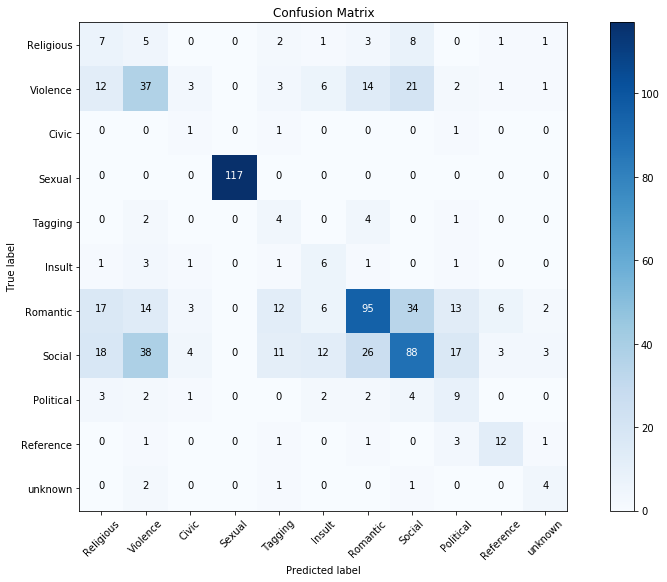

In [72]:
#Create a confusion matrix with the results
conf_matrix = confusion_matrix(y_hat, y_train)
#Create labels for the classes in the conf matrix
class_names = set(y)
#Draw a figure
plt.figure(figsize = (12,8))
#Call the custom function to draw the conf matrix
plot_conf_matrix(conf_matrix, classes = class_names)

This model does passably only on Romantic, Social, and Sexual.

In [ ]:
y_train.value_counts()

<a id = 'model2'></a>

[(Back to top)](#top)

# Model \#2

## Decision tree in progress

In [73]:
# Create label encoder instance
lb = LabelEncoder() 

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 994 entries, 0 to 1033
Data columns (total 15 columns):
CIL IV #                 994 non-null object
Reggio                   994 non-null int32
Insula                   994 non-null int32
Entrance                 994 non-null object
In English               994 non-null object
Literacy                 994 non-null int32
Position                 994 non-null category
Building Type            994 non-null category
Famous House             994 non-null category
Category                 994 non-null category
Writer                   994 non-null category
Flohr Score              994 non-null float64
Socio-economic status    994 non-null category
Characters               994 non-null category
Imperative               994 non-null category
dtypes: category(8), float64(1), int32(3), object(3)
memory usage: 100.7+ KB


In [75]:
# Create Numerical labels for columns
df['Literacy_'] = lb.fit_transform(df['Literacy'])
df['Position_'] = lb.fit_transform(df['Position'])
df['Build_Type_'] = lb.fit_transform(df['Building Type'])
df['Famous_'] = lb.fit_transform(df['Famous House'])
df['Writer_'] = lb.fit_transform(df['Writer'])
df['Econ_Status_'] = lb.fit_transform(df['Socio-economic status'])
df['Imperative_'] = lb.fit_transform(df['Imperative'])
#the target
df['Category_'] = lb.fit_transform(df['Category'])

#Continuous data: Reggio, Insula, Flohr Score, Characters

In [74]:
class_names = set(df['Category'])

In [114]:
# Split features and target variable
X = df[['Literacy_', 'Position_', 'Build_Type_', 'Famous_', 'Writer_', 'Econ_Status_', 'Imperative_', 'Reggio', 'Insula', 'Flohr Score', 'Characters']]
y = df['Category_']

In [115]:
X

Literacy_  Position_  Build_Type_  Famous_  Writer_  Econ_Status_  \
0             1          0           17        0        0             1   
1             0          3            2        0        0             2   
2             0          6            9        0        0             1   
3             1          6            9        0        1             1   
4             0          6            9        0        0             1   
5             0          7           14        0        0             1   
6             1          7           14        0        0             1   
7             0          8            9        0        0             1   
8             0          8            9        0        0             1   
9             1         12            2        0        1             2   
10            0         12            2        0        0             2   
11            0         15            9        0        0             1   
12            1         19            9        0        1             1   
13            1         19            9        0        0             1   
14            0          1            9        1        0             2   
15            0          1            9        1        0             2   
16            1          6            9        1        1             2   
17            1          6            3        0        0             1   
18            0          6            3        0        0             1   
19            1          6            3        0        0             1   
20            1          7            9        1        0             2   
21            0          7           14        0        0             1   
22            1         13            9        1        1             0   
23            0         13            9        1        0             0   
24            0         13            9        1        0             2   
25            1         15            9        1        0             2   
26            1         18            9        1        0             0   
27            0         18            9        1        1             0   
28            1          6            9        1        1             0   
29            1          6            9        0        0             0   
...         ...        ...          ...      ...      ...           ...   
971           1         17            9        1        0             2   
972           1         17            9        1        0             2   
973           0         17            9        1        0             2   
974           0         17            9        1        0             2   
975           1         17            9        1        0             2   
976           1         17            9        1        1             2   
977           0         17            9        1        1             2   
978           1         17            9        1        1             2   
979           0         17            9        1        1             2   
980           1         17            9        1        1             2   
981           1         19           17        0        0             2   
982           0         12           17        0        0             1   
983           1         12           17        0        0             0   
984           1         12           17        0        0             0   
985           0         12           17        0        0             0   
986           0         19            4        0        0             2   
987           0          6           17        0        0             2   
988           0         12           17        0        0             1   
989           0          6           17        0        0             2   
990           0         19           17        0        0             0   
991           0         19           17        0        0             0   
992           0         19     

In [79]:
# Instantiate a one hot encoder
enc = OneHotEncoder()

In [81]:
# Fit the feature set X
enc.fit(X)

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [110]:
enc

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)


In [111]:
# Transform X to onehot array 
onehotX = enc.transform(X)

#onehotX, onehotX.shape, X.shape

In [121]:
onehotX, onehotX.shape, X.shape

(<994x279 sparse matrix of type '<class 'numpy.float64'>'
 	with 10934 stored elements in Compressed Sparse Row format>,
 (994, 279),
 (994, 11))

In [112]:
onehotX = pd.concat([onehotX, df[['Reggio', 'Insula', 'Flohr Score', 'Characters']]], axis = 1)

TypeError: cannot concatenate object of type "<class 'scipy.sparse.csr.csr_matrix'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

In [83]:
#USING ONE HOT
# Create a 70/30 split
X_train, X_test, y_train, y_test = train_test_split(onehotX, y, test_size = 0.3, random_state = 12)

In [116]:
#NOT USING ONE HOT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12)

In [117]:
# Train the classifier and make predictions
clf = DecisionTreeClassifier(criterion = 'entropy')
clf.fit(X_train,y_train) 
y_hat = clf.predict(X_test)

In [118]:
# Calculate Accuracy 
acc = accuracy_score(y_test, y_hat) * 100
print("Accuracy is :{0}".format(acc))

Accuracy is :37.79264214046823


In [ ]:
# Check the AUC for predictions
#false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#roc_auc = auc(false_positive_rate, true_positive_rate)
#print("\nAUC is :{0}".format(round(roc_auc,2)))

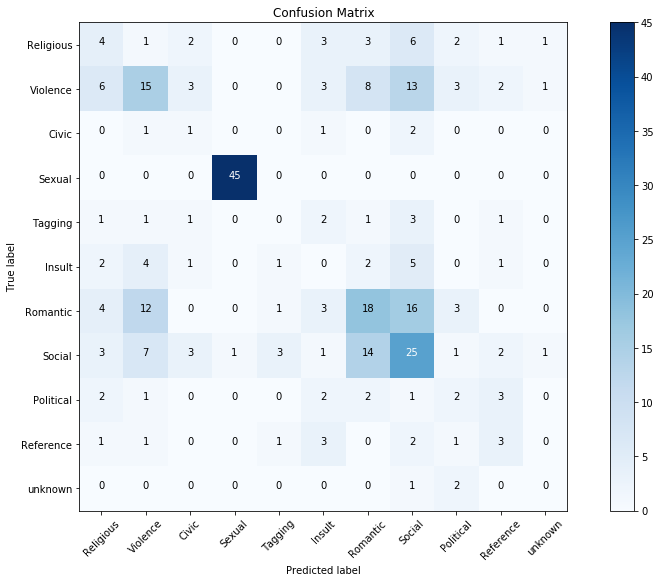

In [119]:
#Create a confusion matrix with the results
conf_matrix = confusion_matrix(y_hat, y_test)
#Create labels for the classes in the conf matrix
#or use labels created before y is encoded
#Draw a figure
plt.figure(figsize = (12,8))
#Call the custom function to draw the conf matrix
plot_conf_matrix(conf_matrix, classes = class_names)

This model performed similarly as poorly as the first logistic regression.

In [87]:
#And now an attempt to use Graph Viz
# Visualize the decision tree using graph viz library 
dot_data = StringIO()

In [88]:
#Feeds from decision tree classifier instantiated above
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True,special_characters=True)

In [89]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 

In [90]:
Image(graph.create_png())

<a id = 'model3'></a>

[(Back to top)](#top)

# Model \#3

In [327]:
#Having reorganized the categories
df = copy.deepcopy(df_raw)

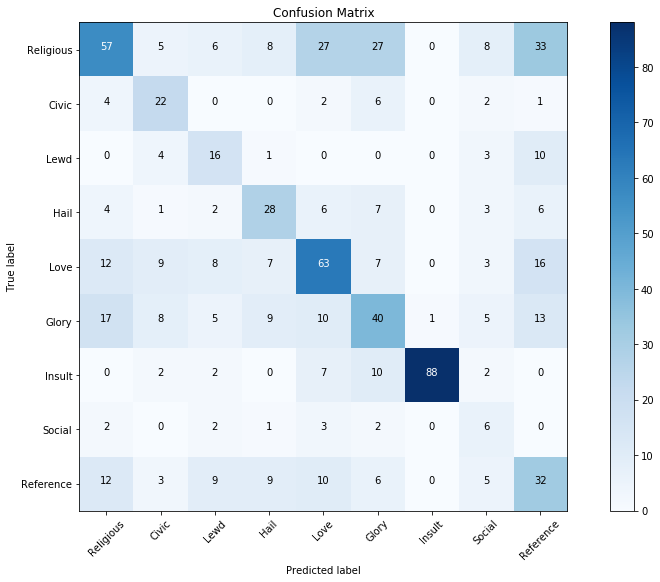

In [329]:
#Make categories
df['Literacy'] = df['Literacy'].astype('category')
df['Position'] = df['Position'].astype('category')
df['Building Type'] = df['Building Type'].astype('category')
df['Famous House'] = df['Famous House'].astype('bool').astype('category')
df['Socio-economic status'] = df['Socio-economic status'].astype('category')
df['Writer'] = df['Writer'].astype('bool').astype('category')
df['Category'] = df['Category'].astype('category')
df['Imperative'] = df['Imperative'].astype('bool').astype('category')

#Continuous data: 'Reggio', 'Insula', 'Characters', 'Flohr Score'

#Get dummies
literacy_dummies = pd.get_dummies(df['Literacy'], prefix = 'Literacy')
position_dummies = pd.get_dummies(df['Position'], prefix = 'Position')
build_type_dummies = pd.get_dummies(df['Building Type'], prefix = 'Building_Type')
famous_dummies = pd.get_dummies(df['Famous House'], prefix = 'Famous')
econ_status_dummies = pd.get_dummies(df['Socio-economic status'], prefix = 'Econ_Status')
writer_dummies = pd.get_dummies(df['Writer'], prefix = 'Writer')
imperative_dummies = pd.get_dummies(df['Imperative'], prefix = 'Imperative')

X = df.drop(['CIL IV #', 'Entrance', 'Literacy', 'In English', 
             'Position', 'Building Type', 
             'Famous House', 'Category', 'Socio-economic status',
             'Writer', 'Imperative'
            ], axis = 1)
X = pd.concat([X, literacy_dummies, position_dummies, build_type_dummies, 
               famous_dummies, econ_status_dummies, writer_dummies,
             imperative_dummies
              ], axis = 1)

y = df['Category']

#Create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)
#print(y_train.value_counts(),'\n', y_test.value_counts())

#Build a logistic regression model
logreg = LogisticRegression(fit_intercept=False, C=1e16)
logreg.fit(X_train, y_train)

y_score = logreg.decision_function(X_test)

y_hat = logreg.predict(X_train)

#Create a confusion matrix with the results
conf_matrix = confusion_matrix(y_hat, y_train)
#Create labels for the classes in the conf matrix
class_names = set(y)
#Draw a figure
plt.figure(figsize = (12,8))
#Call the custom function to draw the conf matrix
plot_conf_matrix(conf_matrix, classes = class_names)

<a id = 'concl'></a>

[(Back to top)](#top)

# Conclusions